In [1]:
# import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils_ses_sstmsit import *
import scipy
from scipy.stats import mode
import seaborn as sns
import statsmodels.api as sm
import statsmodels

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


# extract z stat from ROI

In [2]:
import re

def get_mni_roi_masks_first20():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    return mask_fns

def get_mni_roi_masks_first20_bin():
    mask_fns = get_mni_roi_masks_first20()
    masks_nii = nilearn.image.concat_imgs(mask_fns)
    masks_nii_bin = nilearn.image.math_img('nii*(nii>0.5)', nii=masks_nii)
    return masks_nii_bin
    

## Extract all z-stats from ROI-wise GLM
mask_fns = get_mni_roi_masks_first20()
masks_bin = get_mni_roi_masks_first20_bin()
regex = re.compile('.*MNI152NLin2009cAsym_1mm_label-(?P<ROI>\S+)-(?P<hemisphere>\S).nii.gz')

first_level_copes = {'fs': 0,
                     'ss': 1,
                     'go': 2,
                     'fs-go': 3,
                     'fs-ss': 4,
                     'ss-go': 5
                     }

second_level_copes = {'group mean': 1,
                      '-group mean': 2,
                      'GdH mean': 3,
                      'SM mean': 4,
                      'SJSI mean': 5,
                      'aron mean': 6,
                      'openfmri mean': 7
                      }

contrasts = ['fs', 'ss', 'go', 'fs-go', 'fs-ss', 'ss-go']
flame='12'
slc_n = 1

# Make nifti masker, do some jumbo to make a pretty dataframe
masker = nilearn.maskers.NiftiMapsMasker(masks_bin)
all_zmaps = sorted(glob.glob(f'../derivatives/glm_feat_sst_roi/group_level_model/all_datasets/model-0/model-0/model-0_subjectlevelcontrast-*_grouplevelcontrast-{slc_n}_flame-{flame}_desc-zstat.nii.gz'))
zstat_values = masker.fit_transform(all_zmaps)

def prettify_zstat_df(zstat_values):
    zstat_values = pd.DataFrame(zstat_values, columns=['-'.join(regex.match(x).groupdict().values()) for x in mask_fns], index=contrasts)
    zstat_values = zstat_values.reset_index(names='contrast').melt(id_vars='contrast', var_name='ROI', value_name='zstat')
    zstat_values['ROI_nohemi'] = zstat_values['ROI'].apply(lambda x: x.split('-')[0])
    zstat_values['hemisphere'] = zstat_values['ROI'].apply(lambda x: x.split('-')[1])
    zstat_values.ROI_nohemi = zstat_values.ROI_nohemi.replace({'m1':'M1','gpe':'GPe','gpi':'GPi','sn':'SN','stn':'STN','str':'Str','tha':'Tha','vta':'VTA'})
    zstat_values['ROI'] = zstat_values['ROI_nohemi'] + '-' + zstat_values['hemisphere']

    # Get corresponding p-values and then apply FDR within contrast
    zstat_values['pstat'] = scipy.stats.norm.sf(abs(zstat_values['zstat']))*2  # two-sided test!!
    zstat_values['p_corrected'] = zstat_values.groupby(['contrast'])['pstat'].transform(lambda x: statsmodels.stats.multitest.fdrcorrection(x, method='i')[1])
    zstat_values['significance'] = ''
    zstat_values.loc[zstat_values['p_corrected']<0.05,'significance']='*'
    zstat_values.loc[zstat_values['p_corrected']<=0.01,'significance']='**'
    zstat_values.loc[zstat_values['p_corrected']<=0.001,'significance']='***'
    return zstat_values
zstat_values = prettify_zstat_df(zstat_values)

## Compare with voxel-wise mean z-stats

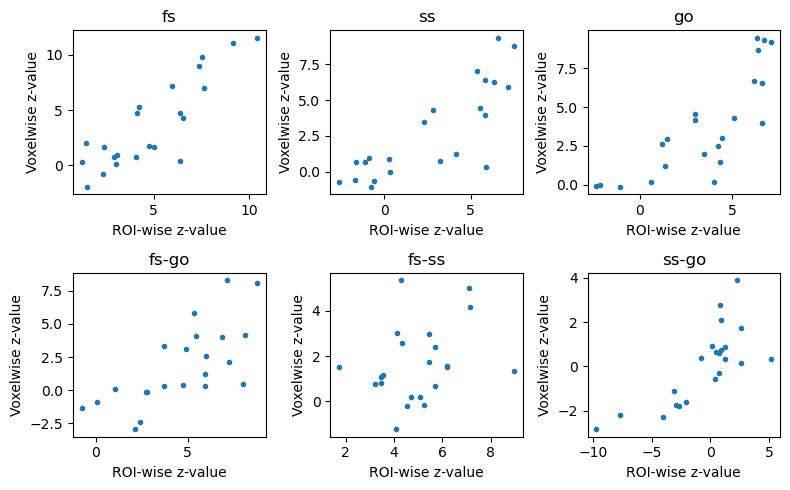

In [3]:
def get_mni_roi_masks_1mm():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
    return mask_fns

def get_mni_roi_masks_1mm_bin():
    mask_fns = get_mni_roi_masks_1mm()
    masks_nii = nilearn.image.concat_imgs(mask_fns)
    masks_nii_bin = nilearn.image.math_img('nii*(nii>0.5)', nii=masks_nii)
    return masks_nii_bin
    

## Extract all z-stats from ROI-wise GLM
mask_fns = get_mni_roi_masks_1mm()
masks_bin = get_mni_roi_masks_1mm_bin()


## Extract all z-stats from ROI-wise GLM
mask_fns = get_mni_roi_masks_1mm()
regex = re.compile('.*MNI152NLin2009cAsym_1mm_label-(?P<ROI>\S+)-(?P<hemisphere>\S).nii.gz')

contrasts = ['fs', 'ss', 'go', 'fs-go', 'fs-ss', 'ss-go']
flame='12'
slc_n = 1

# Make nifti masker, do some jumbo to make a pretty dataframe. Take a bit longer because 1 mm
masker = nilearn.maskers.NiftiMapsMasker(masks_bin)
all_zmaps = sorted(glob.glob(f'../derivatives/glm_feat_hp_sct/group_level_model/all_datasets/fwhm-5p0/model-0/model-0/model-0_fwhm-5p0_subjectlevelcontrast-*_grouplevelcontrast-{slc_n}_flame-{flame}_desc-zstat.nii.gz')) #f'../derivatives/glm_feat_sst_roi/group_level_model/all_datasets/model-0/model-0/model-0_subjectlevelcontrast-*_grouplevelcontrast-{slc_n}_flame-{flame}_desc-zstat.nii.gz'))
zstat_values_voxel = masker.fit_transform(all_zmaps)
zstat_values_voxel = prettify_zstat_df(zstat_values_voxel)

combined = pd.merge(zstat_values, zstat_values_voxel, on=['contrast', 'ROI', 'ROI_nohemi', 'hemisphere'], suffixes=('_ROI', '_voxel'))
f, ax = plt.subplots(2,3, figsize=(8,5))
for i, contrast in enumerate(contrasts):
    ax.ravel()[i].plot(combined.loc[combined.contrast==contrast, 'zstat_ROI'],
                  combined.loc[combined.contrast==contrast, 'zstat_voxel'], '.')
    ax.ravel()[i].set_title(contrast)
    ax.ravel()[i].set_xlabel('ROI-wise z-value')
    ax.ravel()[i].set_ylabel('Voxelwise z-value')
f.tight_layout()

## A reasonable correspondence between both types of analyses in fs, ss, go, ss-go, and fs-go --- fs-ss is worst, but that's likely because it's based on fewest trials

## Make table of ROI-wise z-stat values

In [4]:
def plot_zstat_df(zstat_values):
    # change some namings in the data
    dat = zstat_values.loc[zstat_values['contrast'].isin(['fs-go', 'fs-ss', 'ss-go'])].rename(columns={'contrast':'Contrast'})
    dat = dat.replace({'fs':'FS', 'ss':'SS','go':'GO', 'fs-go':'FS > GO', 'fs-ss':'FS > SS','ss-go':'SS > GO'})
    pmask = dat.pivot('Contrast','ROI','p_corrected')
    dat = dat.pivot('Contrast','ROI','zstat')

    roi_ordered = ['IFG-l','IFG-r','M1-l','M1-r','preSMA-l','preSMA-r','Caudate-l','Caudate-r','GPe-l','GPe-r','GPi-l','GPi-r','Putamen-l','Putamen-r',
                   'SN-l','SN-r','STN-l','STN-r','Tha-l','Tha-r','VTA-l','VTA-r']
    dat = dat.reindex(columns=roi_ordered)
    pmask = pmask.reindex(columns=roi_ordered)

    # mask on z-value of 3.1? Not on significance?
    dat_mask = (pmask < 0.05)

    f = plt.figure(figsize=(15, 7), facecolor='w', edgecolor='k', )
    sns.set(font_scale=0.8)

    g = sns.heatmap(dat, annot=True, center = 0,cmap = 'coolwarm', square = True, fmt='.3g', cbar_kws={"shrink": .46, "ticks":[-10,-8,-6,-4,-2,0,2,4,6,8,10], 'label': 'Z-score'})
    gg = sns.heatmap(dat, mask=dat_mask, cmap=plt.get_cmap('binary'),vmin=2,vmax=2, cbar=False)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(rotation=0,fontsize=10)
    g.set_xlabel('ROI', fontsize=13)
    g.set_ylabel('Contrast',fontsize=13)
    
    return f

/tmp/ipykernel_3786133/1712418268.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pmask = dat.pivot('Contrast','ROI','p_corrected')
/tmp/ipykernel_3786133/1712418268.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','zstat')


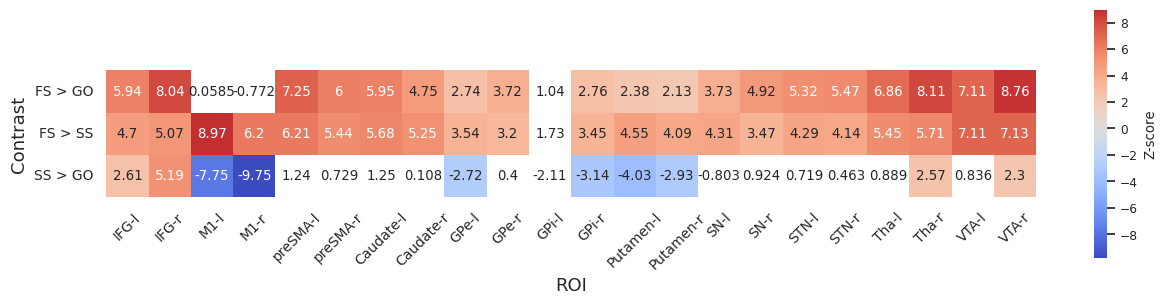

In [5]:
f = plot_zstat_df(zstat_values)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_sm.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

## Excluding GdH's dataset for M1/preSMA

In [6]:
import re

def get_mni_roi_masks_first20():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    return mask_fns

def get_mni_roi_masks_first20_bin():
    mask_fns = get_mni_roi_masks_first20()
    masks_nii = nilearn.image.concat_imgs(mask_fns)
    masks_nii_bin = nilearn.image.math_img('nii*(nii>0.5)', nii=masks_nii)
    return masks_nii_bin
    

## Extract all z-stats from ROI-wise GLM
mask_fns = get_mni_roi_masks_first20()
masks_bin = get_mni_roi_masks_first20_bin()
regex = re.compile('.*MNI152NLin2009cAsym_1mm_label-(?P<ROI>\S+)-(?P<hemisphere>\S).nii.gz')

contrasts = ['fs', 'ss', 'go', 'fs-go', 'fs-ss', 'ss-go']
flame='12'
slc_n = 1

# Make nifti masker, do some jumbo to make a pretty dataframe
masker = nilearn.maskers.NiftiMapsMasker(masks_bin)
all_zmaps = sorted(glob.glob(f'../derivatives/glm_feat_sst_roi_M1preSMA/group_level_model/all_datasets/model-0/model-0/model-0_subjectlevelcontrast-*_grouplevelcontrast-{slc_n}_flame-{flame}_desc-zstat.nii.gz'))
zstat_values_noGdH = masker.fit_transform(all_zmaps)
zstat_values_noGdH = prettify_zstat_df(zstat_values_noGdH)

/tmp/ipykernel_3786133/1712418268.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pmask = dat.pivot('Contrast','ROI','p_corrected')
/tmp/ipykernel_3786133/1712418268.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','zstat')


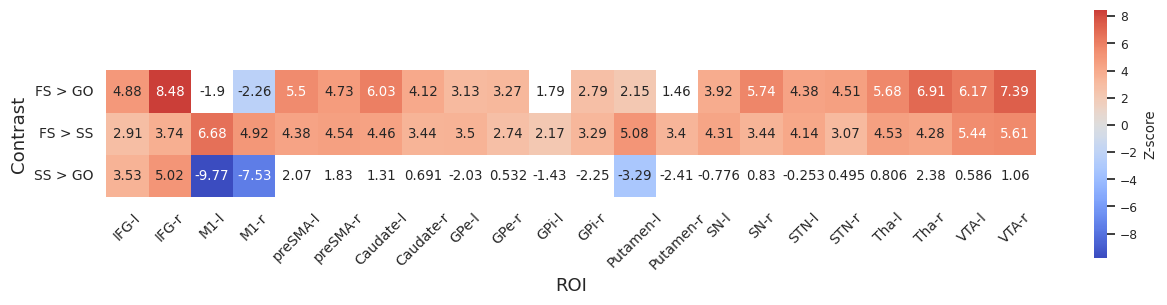

In [7]:
f = plot_zstat_df(zstat_values_noGdH)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_noGdH_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_noGdH_sm.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_noGdH_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

## Combine together into a single table

/tmp/ipykernel_3786133/1712418268.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pmask = dat.pivot('Contrast','ROI','p_corrected')
/tmp/ipykernel_3786133/1712418268.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','zstat')


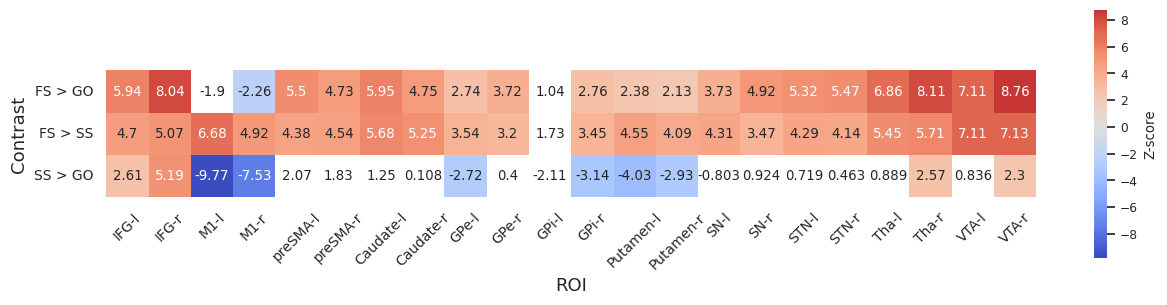

In [8]:
zstat_values.loc[zstat_values.ROI.isin(['M1-l', 'M1-r', 'preSMA-l', 'preSMA-r'])] = zstat_values_noGdH.loc[zstat_values_noGdH.ROI.isin(['M1-l', 'M1-r', 'preSMA-l', 'preSMA-r'])]
f = plot_zstat_df(zstat_values)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_final_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_final_sm.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_final_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

# Time locked to stop signal

In [9]:
import re

def get_mni_roi_masks_first20():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    return mask_fns

def get_mni_roi_masks_first20_bin():
    mask_fns = get_mni_roi_masks_first20()
    masks_nii = nilearn.image.concat_imgs(mask_fns)
    masks_nii_bin = nilearn.image.math_img('nii*(nii>0.5)', nii=masks_nii)
    return masks_nii_bin
    

## Extract all z-stats from ROI-wise GLM
mask_fns = get_mni_roi_masks_first20()
masks_bin = get_mni_roi_masks_first20_bin()
regex = re.compile('.*MNI152NLin2009cAsym_1mm_label-(?P<ROI>\S+)-(?P<hemisphere>\S).nii.gz')

contrasts = ['fs', 'ss', 'go', 'fs-go', 'fs-ss', 'ss-go']
flame='12'
slc_n = 1

# Make nifti masker, do some jumbo to make a pretty dataframe
masker = nilearn.maskers.NiftiMapsMasker(masks_bin)
all_zmaps = sorted(glob.glob(f'../derivatives/glm_feat_sst_roi_timelockstopsignal/group_level_model/all_datasets/model-0/model-0/model-0_subjectlevelcontrast-*_grouplevelcontrast-{slc_n}_flame-{flame}_desc-zstat.nii.gz'))
zstat_values_timelocked = masker.fit_transform(all_zmaps)
zstat_values_timelocked = prettify_zstat_df(zstat_values_timelocked)

/tmp/ipykernel_3786133/1712418268.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pmask = dat.pivot('Contrast','ROI','p_corrected')
/tmp/ipykernel_3786133/1712418268.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','zstat')


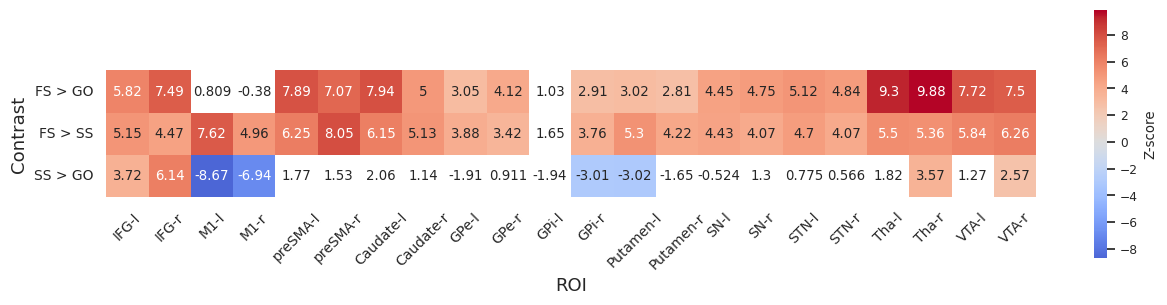

In [10]:
f = plot_zstat_df(zstat_values_timelocked)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_sm.png', bbox_inches='tight', dpi=300)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

# Timelocked to stop signal, no GdH

In [11]:
import re

def get_mni_roi_masks_first20():
    mask_fns = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/useful_masks_mni09c1mm_20vox/*'))
    return mask_fns

def get_mni_roi_masks_first20_bin():
    mask_fns = get_mni_roi_masks_first20()
    masks_nii = nilearn.image.concat_imgs(mask_fns)
    masks_nii_bin = nilearn.image.math_img('nii*(nii>0.5)', nii=masks_nii)
    return masks_nii_bin
    

## Extract all z-stats from ROI-wise GLM
mask_fns = get_mni_roi_masks_first20()
masks_bin = get_mni_roi_masks_first20_bin()
regex = re.compile('.*MNI152NLin2009cAsym_1mm_label-(?P<ROI>\S+)-(?P<hemisphere>\S).nii.gz')

contrasts = ['fs', 'ss', 'go', 'fs-go', 'fs-ss', 'ss-go']
flame='12'
slc_n = 1

# Make nifti masker, do some jumbo to make a pretty dataframe
masker = nilearn.maskers.NiftiMapsMasker(masks_bin)
all_zmaps = sorted(glob.glob(f'../derivatives/glm_feat_sst_roi_M1preSMA_timelockstopsignal/group_level_model/all_datasets/model-0/model-0/model-0_subjectlevelcontrast-*_grouplevelcontrast-{slc_n}_flame-{flame}_desc-zstat.nii.gz'))
zstat_values_timelocked_noGdH = masker.fit_transform(all_zmaps)
zstat_values_timelocked_noGdH = prettify_zstat_df(zstat_values_timelocked_noGdH)

/tmp/ipykernel_3786133/1712418268.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pmask = dat.pivot('Contrast','ROI','p_corrected')
/tmp/ipykernel_3786133/1712418268.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','zstat')


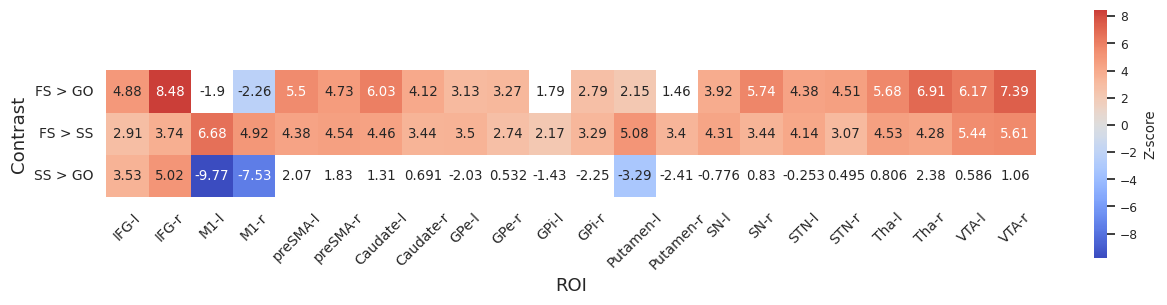

In [12]:
f = plot_zstat_df(zstat_values_timelocked_noGdH)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_noGdH_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_noGdH_sm.png', bbox_inches='tight', dpi=300)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_noGdH_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

/tmp/ipykernel_3786133/1712418268.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pmask = dat.pivot('Contrast','ROI','p_corrected')
/tmp/ipykernel_3786133/1712418268.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  dat = dat.pivot('Contrast','ROI','zstat')


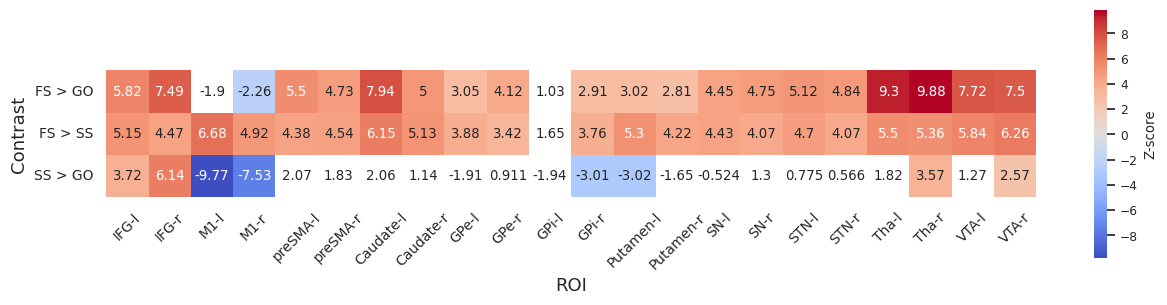

In [13]:
zstat_values_timelocked.loc[zstat_values_timelocked.ROI.isin(['M1-l', 'M1-r', 'preSMA-l', 'preSMA-r'])] = zstat_values_timelocked_noGdH.loc[zstat_values_timelocked_noGdH.ROI.isin(['M1-l', 'M1-r', 'preSMA-l', 'preSMA-r'])]
f = plot_zstat_df(zstat_values_timelocked)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_final_sm.pdf', bbox_inches='tight')
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_final_sm.png', bbox_inches='tight',dpi = 300)
f.savefig('../figures/figures_for_paper/ROI_glm_FEAT_heatmap_zvals_group-level_timelockstopsignal_final_sm.tiff', bbox_inches='tight', dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})